## Notebook Setup

This notebook is a handy catch-all documentation for helper classes/functions I have created importable as the `joosh.py` file found here. For now there is just one key module, but others to be added.

In [1]:
# Typical python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Some display options
pd.set_option('display.max_colwidth', None)

## Cost Matrix Sim

In [2]:
from joosh import cm_sim

### Overview

Imagine we have a binary classification problem in machine learning where we want to define some cost matrix. In such a case, we may want to assign weights to the different ways we could get the problem right or wrong. For instnace, in credit card fraud detection, it might be the case that correctly detecting fraud saves a company X dollars (a true positive), but it also costs the company Y dollars when a label is incorrectly classified as fraud (a false positive).

In such a case, it may be difficult to initially set up those weights without being able to visualize how they affect an eventual models behavior. Thus `cm_sim` attempts a possibly helpful visual by simulating possible scores for a model at various positive and negative error rates, all the while accounting for the provides cost matrix weights.

A typical output looks like the below:

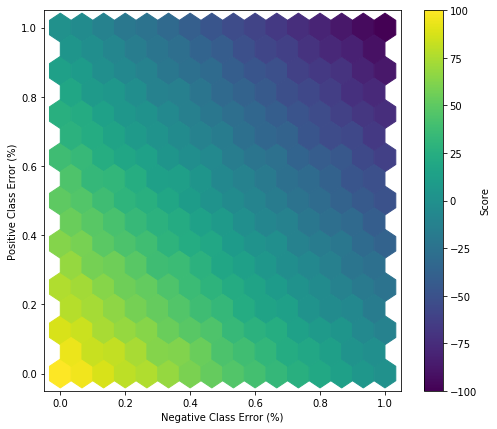

In [3]:
cm_sim()

### Function Parameters

The paremters to this function are as follows:

* `n` (default 100) - The number of samples to consider simulating. A caveat here in that the implementation is somewhat sloppy in terms of optimization (so keeping the record count below 1000 will be faster) and also rounding proportions of a dataset (so nice even powers of 10 work well).
* `propt` (default 0.5) - The proportion of the dataset that is the true/positive class (so 0.5 -> 50%)
* `wtp` (default 1) - The weight (or "cost") associated with true positives
* `wtn` (default 1) - The weight (or "cost") associated with true negatives
* `wfp` (default -1) - The weight (or "cost") associated with false positives
* `wfn` (default -1) - The weight (or "cost") associated with false negatives

### Examples

A fairly simple example might be where we want getting the actual trues to count twice as much as our actual falses. The below then looks like a fairly expected distribution with a slight skew in favor of the positive class error.

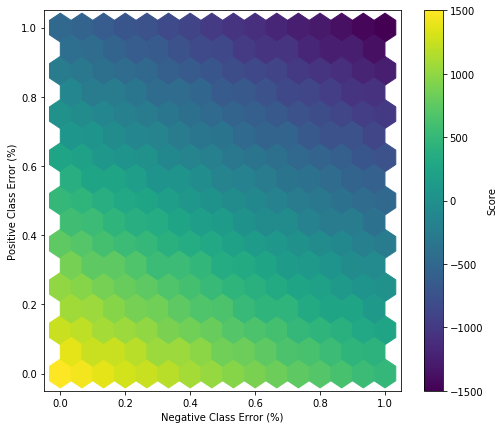

In [6]:
cm_sim(n=1000, propt=0.5, wtp=2, wtn=1, wfp=-1, wfn=-2)

However, image the above case had a strongly imbalanced dataset where only 5% of the data was in the positive class. Below, we can see that even doubling the scores for the actual trues might not be helpful. The score is dominated by the negative class error (since it makes up most of the data) with the positive class error having little effect.

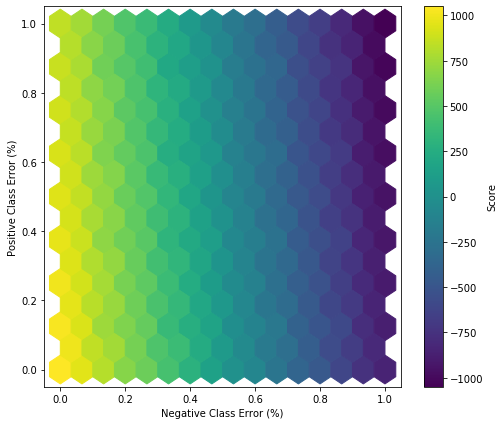

In [7]:
cm_sim(n=1000, propt=0.05, wtp=2, wtn=1, wfp=-1, wfn=-2)

In such a case as above, we might want to weight the actual trues even more to get a helpful cost matrix.

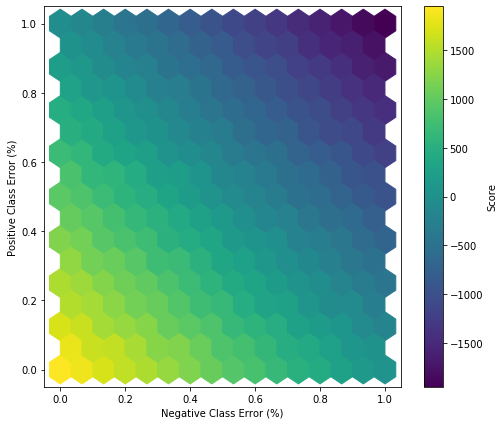

In [9]:
cm_sim(n=1000, propt=0.05, wtp=20, wtn=1, wfp=-1, wfn=-20)

## Stepwise

In [37]:
from joosh import stepwise

### Overview

This helper class `stepwise` can be used to automatically build linear regression models (both OLS and logistic) given a defined feature/target set and desired statistical checks (if any). For now, the implementation only includes simple forward or backwards selection methods.

The framework here uses the `Patsy` implementation of `StatsModels` to build regression formulas similar to those used in R. It assumes:
 * Your data has already been numerically encoded (both target and features) into a `Pandas` dataframe.
 * The data doesn't produce a singular matrix (which causes many statsmodels regression models to fail).
 * The column names don't have any whitespace or invalid characters (see the Patsy docs).

### Statistical Logic

The methodology is simple and always considers the p-value cutoff (as defined by the `pcutval` parameter) to determine whether or not to add/remove a feature.

However, the class can also be asked to consider the following statistical checks by passing the names to the `checks` parameter as part of a list:
 * `AIC` - If the newer model (after addition/removal of a feature) has a higher AIC than the previous model, this check is marked as a failure
 * `BIC` - If the newer model (after addition/removal of a feature) has a higher BIC than the previous model, this check is marked as a failure
 * `R2` - If the newer model (after removal of a feature) has a lower R^2 than the previous model, this check is marked as a failure. Note that for logistic models, pseudo-R2 is used. This is not available for backwards selection since the R^2 will generally decrease.
 * `AdjR2` - If the newer model (after addition/removal of a feature) has a lower adjusted R^2 than the previous model, this check is marked as a failure. Note that for logistic models, a pseudo adjusted R^2 is not available.
 
In the case of forward selection, if any statistical check fails, the feature will not be added even if the p-value for that feature met the cut value.

In the case of backwards selection, if any statistical check fails, the feature will not be removed even if the p-value for that feature did not meet the cut value. In practice, the feature that was previously removed (since it didn't meet the p-value cutoff) will be added back to the model and retain through future builds.

The order of the overall search is defined by a simple ranking of pearson correlation coefficients with the target.

### Class Parameters

The full class build with default values is as follows:

`stepwise(data, target, features, method='forward', target_type='numerical', pcutval=0.05, checks=[]):`

Some notes:
* `data` expects a pandas dataframe
* `target` is the string name of the target feature in the dataframe
* `features` expects a list of strings representing features in the dataframe
* `method` can be either `forward` or `backward`
* `target_type` can be either `numerical` (for OLS) or `categorical` (for logit)
* `pcutval` defaults to 0.05, but set as needed
* `checks` expects a list of strings noting the additional statistical checks to apply (as noted above). A p-value check will always be applied

### Examples

#### Basic OLS Implementation

We'll use the famous wine quality dataset and the red wine subset for a numerical regression example.

In [38]:
# import the dataset and check the general structure
df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The target variable here is `quality`. We'll use all the other columns as predictor features. Since the Statsmodels/Patsy implementation requires getting rid of whitespace, we'll clean our column names and define our lists below.

In [39]:
# Replace whitespace in the colum names
df.columns = df.columns.str.replace(' ', '_')

# Define the target and features
response = 'quality'
predictors = list(df.columns)
predictors.remove(response)

We can create an instance of our `stepwise` class as so below. Note that instantiating the class initializes the feature search.

In [40]:
wine_model = stepwise(data=df, target=response, features=predictors)

We can get the results of the final model by then calling the `final_summary` method.

In [41]:
wine_model.final_summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     111.5
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          6.18e-148
Time:                        08:12:34   Log-Likelihood:                -1570.5
No. Observations:                1599   AIC:                             3159.
Df Residuals:                    1590   BIC:                             3207.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.4878 

And we can review the individuals steps the process took (and the relevant statistics) by viewing the `step_df` attribute which returns a Pandas dataframe.

In [42]:
wine_model.step_df

,Step,Features Used,Current Feature,Added,Stat Checks,Current Pval,R2,AdjR2,AIC,BIC
0,0,[alcohol],alcohol,Added,[No failures],2.831477e-91,0.22673,0.22625,3446.11351,3456.86778
1,1,"[alcohol, volatile_acidity]",volatile_acidity,Added,[No failures],5.557740e-45,0.31700,0.31615,3249.62751,3265.75891
2,2,"[alcohol, volatile_acidity, sulphates]",sulphates,Added,[No failures],2.258238e-11,0.33590,0.33465,3206.76834,3228.27688
3,3,"[alcohol, volatile_acidity, sulphates, citric_acid]",citric_acid,Not added,[ Failure of pvalue],4.460532e-01,0.33614,0.33447,3208.18568,3235.07135
4,4,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide]",total_sulfur_dioxide,Added,[No failures],1.284518e-05,0.34378,0.34214,3189.66928,3216.55495
5,5,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, density]",density,Not added,[ Failure of pvalue],6.164661e-01,0.34389,0.34183,3191.41739,3223.68019
6,6,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides]",chlorides,Added,[No failures],1.432191e-05,0.35149,0.34946,3172.76668,3205.02948
7,7,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, fixed_acidity]",fixed_acidity,Added,[No failures],1.718901e-02,0.35380,0.35137,3169.06295,3206.70289
8,8,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, fixed_acidity, pH]",pH,Added,[No failures],3.874430e-03,0.35718,0.35436,3162.67663,3205.69370
9,9,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, fixed_acidity, pH, free_sulfur_dioxide]",free_sulfur_dioxide,Added,[No failures],1.714299e-02,0.35948,0.35625,3158.96100,3207.35520


#### Changing parameters

Let's re-run the model with some different parameters selected. The step results will be printed to best show the differences.

First let's make the p-value cutoff particularly restrictive.

In [43]:
wine_model = stepwise(data=df, target=response, features=predictors, pcutval=0.01)
wine_model.step_df

,Step,Features Used,Current Feature,Added,Stat Checks,Current Pval,R2,AdjR2,AIC,BIC
0,0,[alcohol],alcohol,Added,[No failures],2.831477e-91,0.22673,0.22625,3446.11351,3456.86778
1,1,"[alcohol, volatile_acidity]",volatile_acidity,Added,[No failures],5.557740e-45,0.31700,0.31615,3249.62751,3265.75891
2,2,"[alcohol, volatile_acidity, sulphates]",sulphates,Added,[No failures],2.258238e-11,0.33590,0.33465,3206.76834,3228.27688
3,3,"[alcohol, volatile_acidity, sulphates, citric_acid]",citric_acid,Not added,[ Failure of pvalue],4.460532e-01,0.33614,0.33447,3208.18568,3235.07135
4,4,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide]",total_sulfur_dioxide,Added,[No failures],1.284518e-05,0.34378,0.34214,3189.66928,3216.55495
5,5,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, density]",density,Not added,[ Failure of pvalue],6.164661e-01,0.34389,0.34183,3191.41739,3223.68019
6,6,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides]",chlorides,Added,[No failures],1.432191e-05,0.35149,0.34946,3172.76668,3205.02948
7,7,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, fixed_acidity]",fixed_acidity,Not added,[ Failure of pvalue],1.718901e-02,0.35380,0.35137,3169.06295,3206.70289
8,8,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, pH]",pH,Added,[No failures],1.828835e-04,0.35717,0.35475,3160.70146,3198.34140
9,9,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, pH, free_sulfur_dioxide]",free_sulfur_dioxide,Not added,[ Failure of pvalue],1.702156e-02,0.35947,0.35665,3156.97688,3199.99395


We can run all viable statistical checks defined above by adding them to the `checks` paremeter.

In [44]:
wine_model = stepwise(data=df, target=response, features=predictors,
                            pcutval=0.01, checks=['AIC', 'BIC', 'R2', 'AdjR2'])
wine_model.step_df

,Step,Features Used,Current Feature,Added,Stat Checks,Current Pval,R2,AdjR2,AIC,BIC
0,0,[alcohol],alcohol,Added,[No failures],2.831477e-91,0.22673,0.22625,3446.11351,3456.86778
1,1,"[alcohol, volatile_acidity]",volatile_acidity,Added,[No failures],5.557740e-45,0.31700,0.31615,3249.62751,3265.75891
2,2,"[alcohol, volatile_acidity, sulphates]",sulphates,Added,[No failures],2.258238e-11,0.33590,0.33465,3206.76834,3228.27688
3,3,"[alcohol, volatile_acidity, sulphates, citric_acid]",citric_acid,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC, Failure of AdjR2]",4.460532e-01,0.33614,0.33447,3208.18568,3235.07135
4,4,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide]",total_sulfur_dioxide,Added,[No failures],1.284518e-05,0.34378,0.34214,3189.66928,3216.55495
5,5,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, density]",density,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC, Failure of AdjR2]",6.164661e-01,0.34389,0.34183,3191.41739,3223.68019
6,6,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides]",chlorides,Added,[No failures],1.432191e-05,0.35149,0.34946,3172.76668,3205.02948
7,7,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, fixed_acidity]",fixed_acidity,Not added,"[ Failure of pvalue, Failure of BIC]",1.718901e-02,0.35380,0.35137,3169.06295,3206.70289
8,8,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, pH]",pH,Added,[No failures],1.828835e-04,0.35717,0.35475,3160.70146,3198.34140
9,9,"[alcohol, volatile_acidity, sulphates, total_sulfur_dioxide, chlorides, pH, free_sulfur_dioxide]",free_sulfur_dioxide,Not added,"[ Failure of pvalue, Failure of BIC]",1.702156e-02,0.35947,0.35665,3156.97688,3199.99395


The methodology defaults to forward selection, but can be changed by the `method` paremeter. Statistical checks work in this mode also; however, note that in the below example `R2` was not added as such a check does not make sense for backwards selection.

In [45]:
wine_model = stepwise(data=df, target=response, features=predictors, method='backward',
                            pcutval=0.01, checks=['AIC', 'BIC', 'AdjR2'])
wine_model.step_df

,Step,Features Used,Feature Removed,Stat Checks,Worst Pval,R2,AdjR2,AIC,BIC
0,0,"[fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol]",density,[No failures],0.408608,0.36055,0.35612,3162.27655,3226.80216
1,1,"[fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, pH, sulphates, alcohol]",fixed_acidity,[No failures],0.612119,0.36028,0.35625,3160.96478,3220.11325
2,2,"[volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, pH, sulphates, alcohol]",residual_sugar,[No failures],0.434276,0.36017,0.35655,3159.22374,3212.99508
3,3,"[volatile_acidity, citric_acid, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, pH, sulphates, alcohol]",citric_acid,[No failures],0.287567,0.35993,0.35671,3157.83914,3206.23335
4,4,"[volatile_acidity, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, pH, sulphates, alcohol]",Worst pvalue is [free_sulfur_dioxide] but stat check failed compared to previous run. No removals and reclaiming [citric_acid] for next run.,[ Failure of AdjR2],0.017022,0.35947,0.35665,3156.97688,3199.99395
5,5,"[volatile_acidity, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, pH, sulphates, alcohol, citric_acid]",free_sulfur_dioxide,[No failures],0.026704,0.35993,0.35671,3157.83914,3206.23335
6,6,"[volatile_acidity, chlorides, total_sulfur_dioxide, pH, sulphates, alcohol, citric_acid]",Worst pvalue is [pH] but stat check failed compared to previous run. No removals and reclaiming [free_sulfur_dioxide] for next run.,"[ Failure of AIC, Failure of AdjR2]",0.000082,0.35795,0.35512,3160.77833,3203.79540
7,7,"[volatile_acidity, chlorides, total_sulfur_dioxide, pH, sulphates, alcohol, citric_acid, free_sulfur_dioxide]",Nothing Removed,[No failures],0.000039,0.35993,0.35671,3157.83914,3206.23335


#### Logistic Example

When `target_type` is set to `categorical`, the `stepwise` class will instead attempt to build a logistic regression model. Note that the class still expects the target to be numerically encoded.

For an example let's use the Sonar dataset.

In [46]:
# import the dataset and check the general structure
df = pd.read_csv('sonar_csv.csv')
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


We'll numerically encode the target class and define our variable sets below.

In [47]:
# Replace whitespace in the colum names
df.columns = df.columns.str.replace(' ', '_')

# Encode the class label
df['Class'] = df['Class'].apply(lambda x: 0 if x == 'Rock' else 1)

# Define the target and features
response = 'Class'
predictors = list(df.columns)
predictors.remove(response)

And finally run the model and print the results. Note that there is no pseudo adjusted R^2 available in the statsmodels implementation to use.

In [48]:
sonar_model = stepwise(data=df, target=response, features=predictors, target_type='categorical',
                             method='forward',pcutval=0.05, checks=['AIC', 'BIC', 'R2'])
sonar_model.final_summary()

                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  208
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                           11
Date:                Mon, 22 Mar 2021   Pseudo R-squ.:                  0.4721
Time:                        08:12:37   Log-Likelihood:                -75.858
converged:                       True   LL-Null:                       -143.70
Covariance Type:            nonrobust   LLR p-value:                 1.223e-23
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.7970      1.017     -4.717      0.000      -6.790      -2.804
attribute_11    11.2015      2.535      4.418      0.000       6.233      16.170
attribute_49    33.5042     10.793      3.10

We can see in the step dataframe that logistic regression follows the same logic as OLS.

In [49]:
sonar_model.step_df

,Step,Features Used,Current Feature,Added,Stat Checks,Current Pval,R2,AdjR2,AIC,BIC
0,0,[attribute_11],attribute_11,Added,[No failures],1.545793e-08,0.15940,N/A,245.59279,252.26787
1,1,"[attribute_11, attribute_12]",attribute_12,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC]",2.049784e-01,0.16492,N/A,246.00576,256.01837
2,2,"[attribute_11, attribute_49]",attribute_49,Added,[No failures],1.596987e-04,0.22254,N/A,229.44575,239.45836
3,3,"[attribute_11, attribute_49, attribute_10]",attribute_10,Not added,"[ Failure of pvalue, Failure of BIC]",1.042952e-01,0.23177,N/A,228.79459,242.14474
4,4,"[attribute_11, attribute_49, attribute_45]",attribute_45,Added,[No failures],3.946876e-02,0.23869,N/A,226.80417,240.15432
5,5,"[attribute_11, attribute_49, attribute_45, attribute_48]",attribute_48,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC]",9.806743e-01,0.23870,N/A,228.80358,245.49128
6,6,"[attribute_11, attribute_49, attribute_45, attribute_9]",attribute_9,Not added,[ Failure of pvalue],3.268102e-01,0.24194,N/A,227.87106,244.55875
7,7,"[attribute_11, attribute_49, attribute_45, attribute_13]",attribute_13,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC, Failure of R2]",4.824873e-01,0.24041,N/A,228.31017,244.99786
8,8,"[attribute_11, attribute_49, attribute_45, attribute_46]",attribute_46,Not added,"[ Failure of pvalue, Failure of AIC, Failure of BIC, Failure of R2]",6.324944e-01,0.23949,N/A,228.57514,245.26283
9,9,"[attribute_11, attribute_49, attribute_45, attribute_47]",attribute_47,Not added,[ Failure of pvalue],4.728825e-01,0.24055,N/A,228.27053,244.95822


Backwards elimination may not be sensible for logistic regression in high cardinality settings however as it can occasionally fail to converge. The implementation here is using `bfgs` as the solver and `maxiter = 1000`, but you may still get convergence warnings. If so, try and start the selection with a smaller, pre-selected list of features.